In [2]:
import pandas as pd

In [3]:
empluzz = pd.read_csv("Unemployment2023.csv")

empluzz = empluzz[(empluzz["Attribute"] == "Median_Household_Income_2022") & (empluzz["Area_Name"].str.contains("County"))]
empluzz.rename(columns={"FIPS_Code": "LocationID", "Value": "Median_Household_Income_2022"}, inplace=True)
empluzz["LocationID"] = empluzz["LocationID"].astype(str)

empluzz = empluzz[["LocationID", "Median_Household_Income_2022"]]
print(empluzz.head())

    LocationID  Median_Household_Income_2022
294       1001                       70148.0
395       1003                       71704.0
496       1005                       41151.0
597       1007                       54309.0
698       1009                       60553.0


In [4]:
census = pd.read_csv("cc-est2024-alldata.csv", encoding="latin-1")

census = census[(census["YEAR"] == 4) & census["AGEGRP"] == 0]

census["LocationID"] = census["STATE"].astype(str).str.zfill(2) + census["COUNTY"].astype(str).str.zfill(3)

census["Pct_Black"] = census["BA_MALE"] + census["BA_FEMALE"]
census["Pct_Hispanic"] = census["H_MALE"] + census["H_FEMALE"]
census["Pct_White"] = census["WA_MALE"] + census["WA_FEMALE"]
census["Pct_Asian"] = census["AA_MALE"] + census["AA_FEMALE"]

census["Pct_Black"] = census["Pct_Black"] / census["TOT_POP"] 
census["Pct_Hispanic"] = census["Pct_Hispanic"] / census["TOT_POP"]
census["Pct_White"] = census["Pct_White"] / census["TOT_POP"]
census["Pct_Asian"] = census["Pct_Asian"] / census["TOT_POP"]

census["LocationID"] = census["LocationID"].astype(str)

census = census[["LocationID", "Pct_Black", "Pct_Hispanic", "Pct_Asian", "Pct_White"]]

In [5]:
df = pd.read_csv("PLACES__Local_Data_for_Better_Health__County_Data_2022_release.csv", engine="python")
df.describe()

,Year,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,LocationID
count,188456.000000,188456.000000,0.0,0.0,188456.000000,188456.000000,1.884560e+05,188456.000000
mean,2019.867513,31.896487,NaN,NaN,29.873414,33.948199,2.100483e+05,30364.077663
std,0.339021,25.146364,NaN,NaN,24.605952,25.746179,5.920674e+06,15178.245358
min,2019.000000,1.700000,NaN,NaN,1.500000,1.900000,8.700000e+01,59.000000
25%,2020.000000,11.300000,NaN,NaN,9.900000,12.800000,1.086700e+04,18173.000000
50%,2020.000000,23.600000,NaN,NaN,21.700000,25.700000,2.558100e+04,29171.000000
75%,2020.000000,44.100000,NaN,NaN,39.300000,50.800000,6.822400e+04,45081.000000
max,2020.000000,93.200000,NaN,NaN,92.600000,93.700000,3.314493e+08,56045.000000


In [6]:
df = df[df["Data_Value_Type"] == "Crude prevalence"].pivot(index=["LocationID", "LocationName"], columns="Short_Question_Text", values="Data_Value").reset_index().dropna()
df["LocationID"] = df["LocationID"].astype(str)
df = pd.merge(df, census, on="LocationID", how="inner").reset_index().dropna()

df = pd.merge(df, empluzz, on="LocationID", how="inner").reset_index().dropna()

print(df.head())


   level_0  index LocationID LocationName  All Teeth Lost  Annual Checkup  \
0        0      0      10001         Kent            11.6            77.3   
1        1      1      10001         Kent            11.6            77.3   
2        2      2      10001         Kent            11.6            77.3   
3        3      3      10001         Kent            11.6            77.3   
4        4      4      10001         Kent            11.6            77.3   

   Arthritis  Binge Drinking  COPD  Cancer (except skin)  ...  \
0       27.4            13.8   8.0                   6.8  ...   
1       27.4            13.8   8.0                   6.8  ...   
2       27.4            13.8   8.0                   6.8  ...   
3       27.4            13.8   8.0                   6.8  ...   
4       27.4            13.8   8.0                   6.8  ...   

   Physical Health  Physical Inactivity  Sleep <7 hours  Stroke  \
0             11.0                 28.4            37.1     3.6   
1           

In [7]:
X = df[["Obesity", "Median_Household_Income_2022", "Pct_Black", "Pct_Hispanic", "Pct_White", "Pct_Asian"]] 
y = df["Diabetes"] / 100

X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
X["Obesity"] = X["Obesity"] / 100

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

/tmp/ipykernel_750682/107659549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
/tmp/ipykernel_750682/107659549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Obesity"] = X["Obesity"] / 100


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


train_X, val_X, train_y, val_y = train_test_split(X_scaled, y, random_state=0)

In [9]:
model = LinearRegression()
model.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [10]:
val_predictions = model.predict(val_X)
mean_absolute_error(val_y, val_predictions)

0.011072415535323862

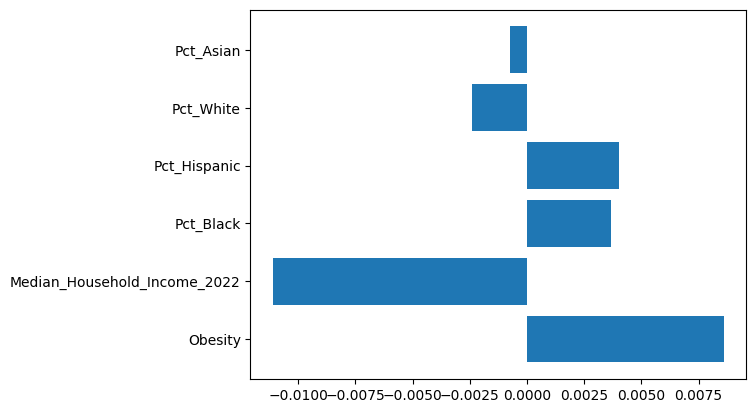

Index(['Obesity', 'Median_Household_Income_2022', 'Pct_Black', 'Pct_Hispanic',
       'Pct_White', 'Pct_Asian'],
      dtype='object') [ 0.00860534 -0.01110521  0.00368129  0.0040041  -0.00242548 -0.0007583 ]


In [11]:
import matplotlib.pyplot as plt

features = X_scaled.columns
coef = model.coef_
plt.barh(features, coef)
plt.show()

print(features, coef)

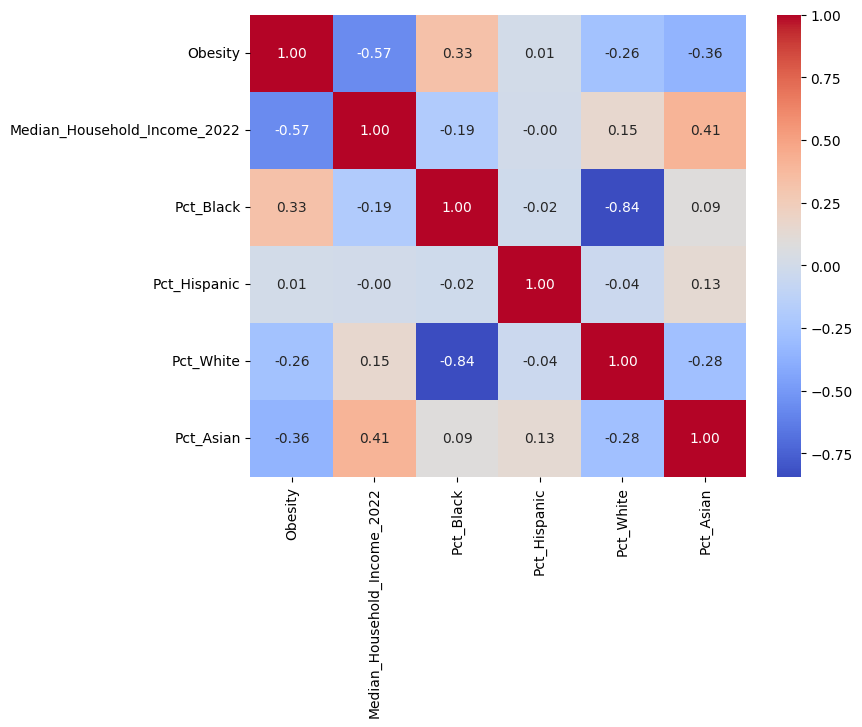

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(X_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

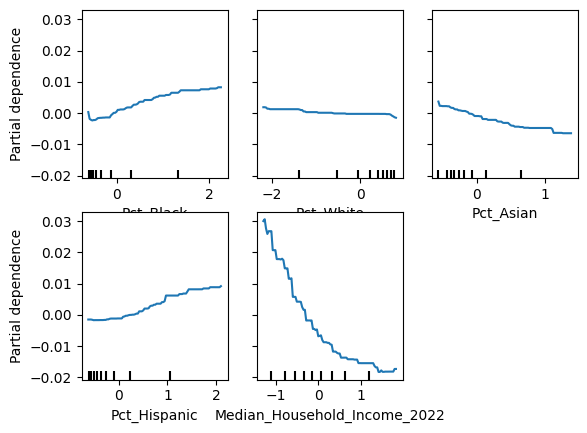

In [13]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(X_scaled, y)
PartialDependenceDisplay.from_estimator(gb_model, X_scaled, features=["Pct_Black", "Pct_White", "Pct_Asian", "Pct_Hispanic", "Median_Household_Income_2022"])
plt.show()

In [14]:
std_df = pd.DataFrame({"Feature": X.columns, "Standard Deviation": scaler.scale_})

print(std_df)

                        Feature  Standard Deviation
0                       Obesity            0.042230
1  Median_Household_Income_2022           15.103879
2                     Pct_Black            0.132896
3                  Pct_Hispanic            0.140608
4                     Pct_White            0.153551
5                     Pct_Asian            0.024997


In [15]:
df[["Pct_Asian", "Diabetes"]].corr()


,Pct_Asian,Diabetes
Pct_Asian,1.000000,-0.271359
Diabetes,-0.271359,1.000000


<Axes: xlabel='Pct_Black', ylabel='Diabetes'>

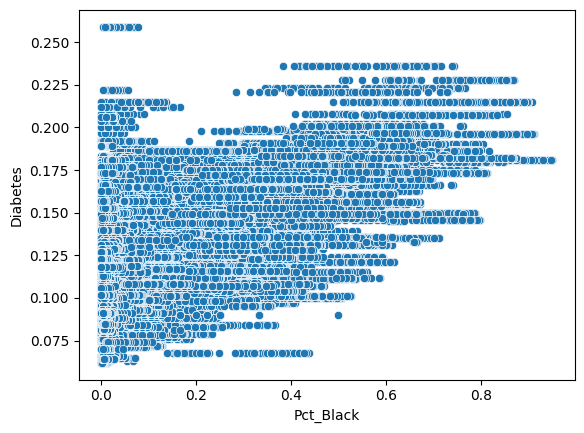

In [16]:
sns.scatterplot(x="Pct_Black", y=y, data=df)

In [17]:
df[df['Median_Household_Income_2022'] > 80000][['Pct_White', 'Diabetes']].corr()

,Pct_White,Diabetes
Pct_White,1.000000,-0.136769
Diabetes,-0.136769,1.000000


In [18]:
df[(df["Median_Household_Income_2022"] > 60000) & (df["Median_Household_Income_2022"] < 79999)][["Pct_White", "Diabetes"]].corr()


,Pct_White,Diabetes
Pct_White,1.000000,-0.196261
Diabetes,-0.196261,1.000000


In [19]:
df[["Pct_Asian", "Obesity"]].corr()

,Pct_Asian,Obesity
Pct_Asian,1.000000,-0.357522
Obesity,-0.357522,1.000000


In [20]:
df[df["Pct_Asian"] > 0.2]["Annual Checkup"].mean()


np.float64(75.27669683257918)

In [21]:
df["Annual Checkup"].mean()


np.float64(75.64929572492674)